**Notebook V0 prediction du geste**
- Mediapipe pour obtenir les coordonnées de la main à partir des images shifumi (réelles + synthèses)
- Classifier Kmeans et KNN pour prédire le geste

**I. Mediapipe hand landmarks detection**

**1. Dataset**

In [1]:
!pip install mediapipe opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
import mediapipe as mp
import cv2
import numpy as np
import uuid
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random

In [3]:
drawingModule = mp.solutions.drawing_utils
handsModule = mp.solutions.hands
hands = handsModule.Hands(static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.8)

**ATTENTION** : cette partie peut être ignorée si l'on dispose du fichier landmarks.csv

Ignorez jusqu'à la section II. Classifier knn

In [8]:
# Dataset infos

dataset_path = "dataset_reel"

print(dataset_path)
labels = []
labels_size = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
    labels_size.append(len(os.listdir(os.path.join(dataset_path, i))))
print(labels)
print(labels_size)

dataset_reel


FileNotFoundError: [Errno 2] No such file or directory: 'dataset_reel'

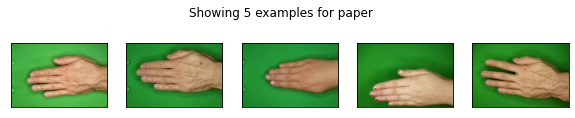

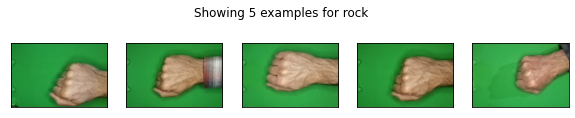

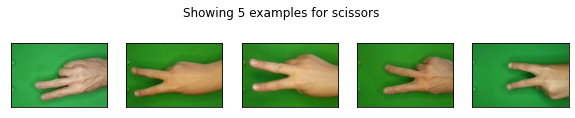

In [ ]:
# Dataset visualization

NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(dataset_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

**2. Test Mediapipe**

In [6]:


def processImage(image_path):
    image = cv2.imread(image_path)
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks != None:
        for handLandmarks in results.multi_hand_landmarks:
            drawingModule.draw_landmarks(image, handLandmarks, handsModule.HAND_CONNECTIONS)
    return image



In [7]:
image = cv2.imread(os.path.join(label_dir, example_filenames[3]))

results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

if results.multi_hand_landmarks != None:
    for handLandmarks in results.multi_hand_landmarks:
        drawingModule.draw_landmarks(image, handLandmarks, handsModule.HAND_CONNECTIONS)

    plt.imshow(image)


NameError: name 'label_dir' is not defined

**2. Prétraitement des données**

In [ ]:
# Data augmentation

def random_rotation(image):
    angle = random.randint(0, 90)
    rows, cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(image, rotation_matrix, (cols, rows))

def random_flip(image):
    flip_type = random.choice([-1, 0, 1]) # -1: horizontal and vertical, 0: vertical, 1: horizontal
    return cv2.flip(image, flip_type) if random.random() < 0.75 else image

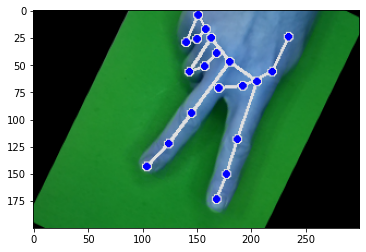

In [ ]:
# Test rotation

image = cv2.imread(os.path.join(label_dir, example_filenames[3]))
image2 = random_rotation(image)

results = hands.process(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

if results.multi_hand_landmarks != None:
    for handLandmarks in results.multi_hand_landmarks:
        drawingModule.draw_landmarks(image2, handLandmarks, handsModule.HAND_CONNECTIONS)

    plt.imshow(image2)

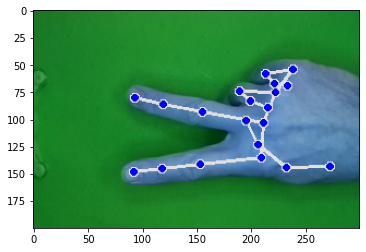

In [ ]:
# test flip

image = cv2.imread(os.path.join(label_dir, example_filenames[3]))
image2 = random_flip(image)
#plt.imshow(image2)

results = hands.process(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

if results.multi_hand_landmarks != None:
    for handLandmarks in results.multi_hand_landmarks:
        drawingModule.draw_landmarks(image2, handLandmarks, handsModule.HAND_CONNECTIONS)

    plt.imshow(image2)

**3. Fonctions pour récuperer et formater les coordonnées de la main**

In [ ]:
# Landmark extraction

def landmarkPoint(image, path=True):
    if path:
        image = cv2.imread(image)
    image = random_rotation(image)
    image = random_flip(image)
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks != None:
        for handLandmarks in results.multi_hand_landmarks:
            return handLandmarks


def landmarkFormat(handLandmarks):

    def normalize(landmarks):
        x = np.array([landmark.x for landmark in landmarks])
        y = np.array([landmark.y for landmark in landmarks])
        z = np.array([landmark.z for landmark in landmarks])
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
        y = (y - np.min(y)) / (np.max(y) - np.min(y))
        z = (z - np.min(z)) / (np.max(z) - np.min(z))
        return (x, y, z)

    def cartesian_to_polar(landmarks):
        x, y, z = normalize(landmarks)
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.where(r != 0, np.arccos(z/r), 0)
        phi = np.where(x != 0, np.arctan2(y, x), 0)
        return np.array([r, theta, phi]).T

    return cartesian_to_polar(handLandmarks.landmark)

image_path = os.path.join(dataset_path, labels[0], os.listdir(os.path.join(dataset_path, labels[0]))[0])
hand = landmarkPoint(image_path)
handf = landmarkFormat(hand)
# print(hand)
print(handf)


[[1.28755428 0.68144026 0.        ]
 [1.19664459 1.02050466 1.3725082 ]
 [1.16344466 1.17562645 1.17259169]
 [1.11128724 1.25774772 0.97104988]
 [1.10838501 1.34916786 0.80920397]
 [0.95615734 1.06547035 0.89636294]
 [0.92044364 1.32340228 0.55455489]
 [0.9680268  1.48225472 0.38501444]
 [1.03577777 1.57079633 0.26360064]
 [0.85959462 0.88977912 0.82208769]
 [0.83616145 1.18554406 0.41937353]
 [0.90369044 1.38462532 0.224355  ]
 [0.99206896 1.49705524 0.10671138]
 [0.79944286 0.71564439 0.79766649]
 [0.75038335 1.00933622 0.32918997]
 [0.79215701 1.25897569 0.12892595]
 [0.87305497 1.40217876 0.01457906]
 [0.76338328 0.56125736 0.84885292]
 [0.6477198  0.80970064 0.35181749]
 [0.64546017 1.03299202 0.1305401 ]
 [0.69813012 1.17096476 0.        ]]


In [5]:
# training data

all_transformed_landmarks = [] # Liste pour stocker les vecteurs de landmarks transformés

labels_data = []
path_data = []
for i, label in enumerate(labels):
    images_path = os.path.join(dataset_path, label)
    for image_name in os.listdir(images_path):
        image_path = os.path.join(images_path, image_name)
        hand = landmarkPoint(image_path)
        if hand is not None:  # S'assurer qu'au moins une main a été détectée
            handf = landmarkFormat(hand)
            if handf.any():  # S'assurer que la transformation a été réussie
                all_transformed_landmarks.append(handf)
                labels_data.append(i)
                path_data.append(image_path)
            # if len(labels_data) == 100*(1+i):
            #     break


# Affichage de la taille de la liste pour confirmer le traitement
print(f"Nombre total d'images traitées : {len(all_transformed_landmarks)}")
print(all_transformed_landmarks[0])
data = np.array([np.ravel(landmarks) for landmarks in all_transformed_landmarks])


NameError: name 'labels' is not defined

In [ ]:
print(data.shape)
print(len(labels_data))
print(len(path_data))


(1720, 63)
1720
1720


In [4]:
# create a csv file
import csv

with open('landmarks.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["label", "label_name", "path", "landmarks"])
    for i in range(len(labels_data)):
        #landmarks is a list of floats
        writer.writerow([labels_data[i] , labels[labels_data[i]], path_data[i], data[i]])

NameError: name 'labels_data' is not defined

**ATTENTION** : Reprendre ici

**II. Classifier KNN**

**1. Entrainement du modèle**

In [ ]:
# récuperer le fichier csv
import numpy as np
import csv
data_from_csv = []
labels_from_csv = []
path_from_csv = []
with open('/content/landmarks.csv', newline='') as file:
    reader = csv.reader(file)
    # skip the header
    next(reader)
    for row in reader:
        #convert to float
        data_from_csv.append(np.array(row[3][1:-1].split()).astype(float))
        labels_from_csv.append(row[0])
        path_from_csv.append(row[2])

data_from_csv = np.array(data_from_csv)
labels_from_csv = np.array(labels_from_csv).astype(int)
path_from_csv = np.array(path_from_csv)


## Ces fonctions définient dans la section précédente sont utiles pour la suite

def landmarkPoint(image, path=True):
    if path:
        image = cv2.imread(image)
    image = random_rotation(image)
    image = random_flip(image)
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks != None:
        for handLandmarks in results.multi_hand_landmarks:
            return handLandmarks


def landmarkFormat(handLandmarks):

    def normalize(landmarks):
        x = np.array([landmark.x for landmark in landmarks])
        y = np.array([landmark.y for landmark in landmarks])
        z = np.array([landmark.z for landmark in landmarks])
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
        y = (y - np.min(y)) / (np.max(y) - np.min(y))
        z = (z - np.min(z)) / (np.max(z) - np.min(z))
        return (x, y, z)

    def cartesian_to_polar(landmarks):
        x, y, z = normalize(landmarks)
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.where(r != 0, np.arccos(z/r), 0)
        phi = np.where(x != 0, np.arctan2(y, x), 0)
        return np.array([r, theta, phi]).T

    return cartesian_to_polar(handLandmarks.landmark)


In [ ]:
# Landmark extraction

def landmarkPoint(image, path=True):
    if path:
        image = cv2.imread(image)
    image = random_rotation(image)
    image = random_flip(image)
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks != None:
        for handLandmarks in results.multi_hand_landmarks:
            return handLandmarks


def landmarkFormat(handLandmarks):

    def normalize(landmarks):
        x = np.array([landmark.x for landmark in landmarks])
        y = np.array([landmark.y for landmark in landmarks])
        z = np.array([landmark.z for landmark in landmarks])
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
        y = (y - np.min(y)) / (np.max(y) - np.min(y))
        z = (z - np.min(z)) / (np.max(z) - np.min(z))
        return (x, y, z)

    def cartesian_to_polar(landmarks):
        x, y, z = normalize(landmarks)
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.where(r != 0, np.arccos(z/r), 0)
        phi = np.where(x != 0, np.arctan2(y, x), 0)
        return np.array([r, theta, phi]).T

    return cartesian_to_polar(handLandmarks.landmark)


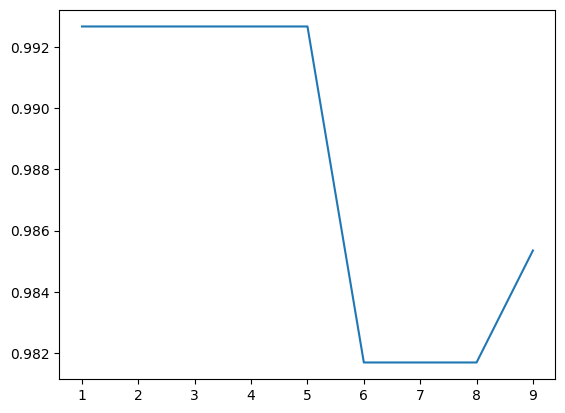

In [ ]:
#k nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# df = data
# df_labels = labels_data

df = data_from_csv
df_labels = labels_from_csv

# cross validation to choose the best k
X_train1, X_test, y_train1, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)
X_train2, X_validation, y_train2, y_validation = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)
scores = []
for k in range(1, 10):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train2, y_train2)
    y_pred = model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    scores.append(accuracy)
plt.plot(range(1, 10), scores)


In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [ ]:
model = KNeighborsClassifier(n_neighbors=2) #metric= 'euclidean' or 'cosine
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9941348973607038


In [ ]:
from google.colab.patches import cv2_imshow

**2. test en temps réel**

In [ ]:
# Ouverture du flux vidéo
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                        min_detection_confidence=0.8)

while cap.isOpened():
    success, image = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        continue

    # Conversion de l'image de BGR à RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Dessin des landmarks de la main
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Transformation et prédiction du cluster
            x0, y0, z0 = hand_landmarks.landmark[0].x, hand_landmarks.landmark[0].y, hand_landmarks.landmark[0].z
            transformed_landmarks = landmarkFormat(hand_landmarks)
            transformed_landmarks_flat = np.ravel(transformed_landmarks).reshape(1, -1)
            cluster_label = model.predict(transformed_landmarks_flat)

            # Affichage du cluster sur l'image
            if cluster_label == 0:
                cv2.putText(image, 'Feuille', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            elif cluster_label == 1:
                cv2.putText(image, 'Pierre', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            elif cluster_label == 2:
                cv2.putText(image, 'Ciseaux', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            else:
                cv2.putText(image, 'Inconnu', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            # Afficher la plus proche distance
            nearest_neighbors = model.kneighbors(transformed_landmarks_flat, 5)
            mean_distance = np.mean(nearest_neighbors[0][0])
            # cv2.putText(image, 'Distance: {:.2f}'.format(mean_distance), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            #cv2.putText(image, 'Cluster: {}'.format(cluster_label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Affichage de l'image résultante
    # cv2.imshow('MediaPipe Hands', image)
    ### spécifiqua à Colab

    cv2_imshow(image)
    print('test')


    # Arrêt avec la touche 'q'
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))